# **Cataract Detection Using PyTorch SqueezeNet 1.1**

**Authored by: Zander Brumbaugh**

This application serves as a practical and accurate tool for detecting cataracts of the eyes. Users will be able to use this as a reference before seeing an optometrist while only needing a computer.

After exploring the options for classification models, such as AlexNet and more, SqueezeNet 1.1 was chosen as it is lightweight and accurate with training on limited datasets. The images for the dataset were collected by me and include 50 unique images of cataract eyes and 50 unique images of healthy eyes.

## **Initialization**

Set and replace number of classes for the base model.

In [1]:
#@title Model info: { vertical-output: true }

import os, time, copy
import torch, torchvision

from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch import optim

# Binary "cataract" or "healthy" classification
num_classes = 2 #@param {type:"integer"}

# Load pretrained model, replace num of parameters in classifier, and evaluate

model = torchvision.models.squeezenet1_1(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model.eval()

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

If you have a trained model, upload and load from your .pth file. Alternatively, you can use ours by running the block with the wget command.

In [ ]:
# This notebook uses the GDown library to retrieve files from Google Drive
# You can switch to wget to get files from any URL.

!gdown -O "TrainedModel.pth" --id 1W2Fm0RKenjZ8Owx_T3uqVBwbNlFpa8d_

In [10]:
#@title Trained model path: { vertical-output: true }
path_to_state_dict = "TrainedModel.pth" #@param {type:"string"}

loadedDict = None

if torch.cuda.is_available():
  loadedDict = torch.load(path_to_state_dict)
else:
  loadedDict = torch.load(path_to_state_dict, map_location=torch.device('cpu'))

model.load_state_dict(loadedDict)



<All keys matched successfully>

## **Training**

Train a model using your own dataset or simply observe the process with ours

If you have loaded a .pth into your model already, you can skip this entire section. Otherwise, start by downloading our cataract detection training and value set. You can also create your own with more data for even further accuracy.

In [2]:
# A limited dataset collected by me

#@title Training set info: { vertical-output: true }
set_id = "1ZoMKFDmYFukg3f7LTVW3gFJVBeQ0lYw5" #@param {type:"string"}
set_file_name = "CataractDetectionSet.zip" #@param {type:"string"}
unzipped_set_dir_name = "CataractDetectionSet" #@param {type:"string"}

!gdown -O {set_file_name} --id {set_id}
!unzip {set_file_name}
!rm {set_file_name}

Downloading...
From: https://drive.google.com/uc?id=1ZoMKFDmYFukg3f7LTVW3gFJVBeQ0lYw5
To: /content/CataractDetectionSet.zip
26.5MB [00:00, 63.7MB/s]
Archive:  CataractDetectionSet.zip
   creating: CataractDetectionSet/train/
   creating: CataractDetectionSet/train/cataracts/
  inflating: CataractDetectionSet/train/cataracts/200px-Intumescent_cataract.jpg  
  inflating: CataractDetectionSet/train/cataracts/597204371_Crop.jpg  
  inflating: CataractDetectionSet/train/cataracts/800wm.jpg  
  inflating: CataractDetectionSet/train/cataracts/Can-Cataracts-cause-Blindness.jpg  
  inflating: CataractDetectionSet/train/cataracts/cataract_prevention.png  
  inflating: CataractDetectionSet/train/cataracts/cataract-canstockphoto.jpg  
  inflating: CataractDetectionSet/train/cataracts/cataract-eye.jpg  
  inflating: CataractDetectionSet/train/cataracts/cataracts eye  closeup hero.jpg  
  inflating: CataractDetectionSet/train/cataracts/cataract-surgery-complications-1200x630.jpg  
  inflating: Catar

Create dataset from folder and set transforms.

In [3]:
#@title Training info: { vertical-output: true }

batch_size = 8 #@param {type:"integer"}
data_dir = unzipped_set_dir_name

# Keep true if you're simply replacing the classifying layer
feature_extract = True #@param {type:"boolean"}

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Implement optimizer.

In [4]:
# Send the model to GPU
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


Definte training function.

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Begin training. 15 epochs provides consistently good results with our limited dataset in as little as 1-2 mins.

In [6]:
# As little as 15 epochs produces a very good and consistent result

#@title How many training epochs? { vertical-output: true }
num_epochs =  15 #@param {type:"integer"}

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_name = "squeezenet"
model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.8549 Acc: 0.5000
val Loss: 0.5242 Acc: 0.7800

Epoch 1/14
----------
train Loss: 0.3977 Acc: 0.9000
val Loss: 0.4361 Acc: 0.8600

Epoch 2/14
----------
train Loss: 0.3628 Acc: 0.9000
val Loss: 0.4372 Acc: 0.8200

Epoch 3/14
----------
train Loss: 0.2958 Acc: 0.8600
val Loss: 0.3357 Acc: 0.8800

Epoch 4/14
----------
train Loss: 0.2566 Acc: 0.9000
val Loss: 0.3121 Acc: 0.8600

Epoch 5/14
----------
train Loss: 0.1632 Acc: 0.9400
val Loss: 0.2198 Acc: 0.9000

Epoch 6/14
----------
train Loss: 0.1653 Acc: 0.9400
val Loss: 0.2377 Acc: 0.8600

Epoch 7/14
----------
train Loss: 0.1654 Acc: 0.9200
val Loss: 0.2466 Acc: 0.8600

Epoch 8/14
----------
train Loss: 0.1297 Acc: 0.9400
val Loss: 0.2111 Acc: 0.9400

Epoch 9/14
----------
train Loss: 0.1896 Acc: 0.9600
val Loss: 0.2425 Acc: 0.9000

Epoch 10/14
----------
train Loss: 0.1461 Acc: 0.9600
val Loss: 0.1881 Acc: 0.9400

Epoch 11/14
----------
train Loss: 0.2424 Acc: 0.8800
val Loss: 0.2053 Acc: 0.9200

Epoch 12/14
----------
t

Save your trained model for future use. Once saved, you can download the file from the file explorer on the left side of the notebook and upload it in future Google Colab sessions.

In [7]:
#@title Trained model file name: { vertical-output: true }
trained_model_name = "TrainedModel.pth" #@param {type:"string"}
torch.save(model.state_dict(), trained_model_name)

## **Test with a Sample**

Load sample image.

--2021-09-27 19:15:20--  https://www.belmarrahealth.com/wp-content/uploads/2016/03/prevent-cataracts-naturally-home-remedies-500x339.jpg
Resolving www.belmarrahealth.com (www.belmarrahealth.com)... 104.130.198.86
Connecting to www.belmarrahealth.com (www.belmarrahealth.com)|104.130.198.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24703 (24K) [image/jpeg]
Saving to: ‘eye.jpg’

eye.jpg             100%[===================>]  24.12K   145KB/s    in 0.2s    

2021-09-27 19:15:22 (145 KB/s) - ‘eye.jpg’ saved [24703/24703]

tensor([9.2028, 1.3705])
tensor([9.9960e-01, 3.9657e-04])


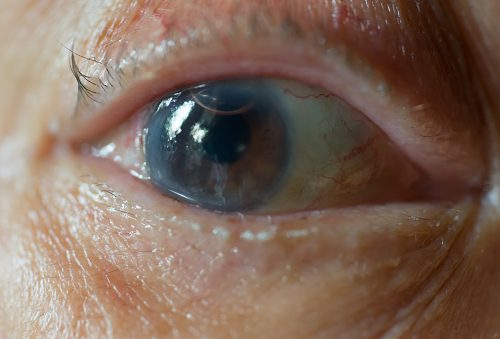

In [8]:
# Download image sample. Must be RGB 3-channel image, .jpg, etc.

#@title Image info: { vertical-output: true }
image_url = "https://www.belmarrahealth.com/wp-content/uploads/2016/03/prevent-cataracts-naturally-home-remedies-500x339.jpg" #@param {type:"string"}

# Make sure image name matches file type
image_name = "eye.jpg" #@param {type:"string"}

!wget -O {image_name} {image_url}

# sample execution (requires torchvision)
import cv2
from PIL import Image
from torchvision import transforms
from google.colab.patches import cv2_imshow

input_image = Image.open(image_name)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

print(probabilities)

img = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Get file of image class labels.

In [9]:
# Download labels
#@title Label info: { vertical-output: true }
label_set_id = "1RHJOYxr3KSMkfNtY3MhiaiU66taHUmA_" #@param {type:"string"}
label_set_file_name = "EyeLabels.txt" #@param {type:"string"}

!gdown -O {label_set_file_name} --id {label_set_id}

Downloading...
From: https://drive.google.com/uc?id=1RHJOYxr3KSMkfNtY3MhiaiU66taHUmA_
To: /content/EyeLabels.txt
100% 17.0/17.0 [00:00<00:00, 12.6kB/s]


Read classification results.

In [10]:
#@title  { vertical-output: true }
# Read the categories
with open(label_set_file_name, "r") as f:
    categories = [s.strip() for s in f.readlines()]
    
# Show top categories per image
num_classes_to_show = 2 #@param {type:"integer"}
num_classes_to_show = min(num_classes_to_show, num_classes)

top_prob, top_catid = torch.topk(probabilities, num_classes_to_show)
for i in range(top_prob.size(0)):
    print(categories[top_catid[i]] + ":", top_prob[i].item())

cataract: 0.9996034502983093
healthy: 0.00039657350862398744
